# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torch.nn.utils import spectral_norm
import torch.nn.functional as F

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    transforms = transforms = [
        Resize(size), 
        ToTensor(), 
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        self.files = glob(f'{directory}/*{extension}')

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        return len(self.files)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        image = Image.open(self.files[index])
        if self.transforms:
            image = self.transforms(image)

        return image

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

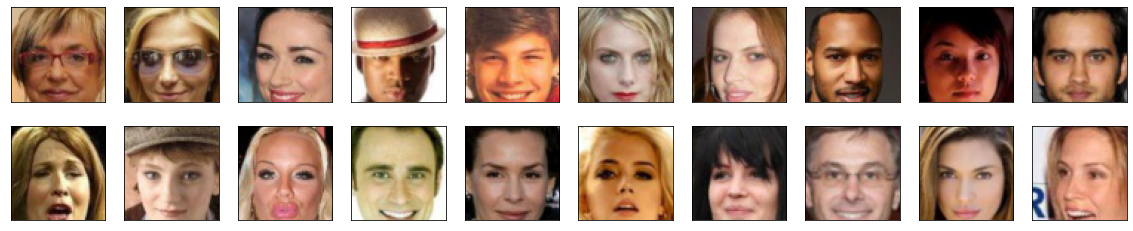

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
import torch
import torch.nn as nn


In [8]:
# Define a convolutional block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, batch_norm=True):
        super(ConvBlock, self).__init__()
        layers = [spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [9]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            ConvBlock(3, 64, 4, 2, 1, batch_norm=False),
            ConvBlock(64, 128, 4, 2, 1),
            ConvBlock(128, 256, 4, 2, 1),
            ConvBlock(256, 512, 4, 2, 1),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(self.main(x + torch.randn_like(x) * 0.1))
       

In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [11]:
# Define a transposed convolutional block
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, batch_norm=True):
        super(DeconvBlock, self).__init__()
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


In [12]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            DeconvBlock(latent_dim, 512, 4, 1, 0),
            DeconvBlock(512, 256, 4, 2, 1),
            DeconvBlock(256, 128, 4, 2, 1),
            DeconvBlock(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x)

In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [14]:
import torch.optim as optim

def create_optimizers(generator: nn.Module, discriminator: nn.Module):
    """ This function should return the optimizers of the generator and the discriminator """
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999)) 
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [15]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    return -torch.mean(fake_logits)


### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [16]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    return torch.mean(fake_logits) - torch.mean(real_logits)

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [17]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    interpolated_logits = discriminator(interpolated)

    gradients = torch.autograd.grad(
        outputs=interpolated_logits,
        inputs=interpolated,
        grad_outputs=torch.ones(interpolated_logits.size(), device=real_samples.device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradients_norm = gradients.norm(2, dim=1)
    return ((gradients_norm - 1) ** 2).mean()

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [18]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # Update Generator
    g_optimizer.zero_grad()
    z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(z)
    fake_logits = discriminator(fake_images)
    g_loss = generator_loss(fake_logits)
    g_loss.backward()
    g_optimizer.step()
        
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    gp = None

    # Update Discriminator
    d_optimizer.zero_grad()
    z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(z)
    real_logits = discriminator(real_images)
    fake_logits = discriminator(fake_images)
    d_loss = discriminator_loss(real_logits, fake_logits)
    
    # Gradient Penalty
    gp = gradient_penalty(discriminator, real_images, fake_images)
    d_loss += 10 * gp  # Weight of the gradient penalty
    
    d_loss.backward()
    d_optimizer.step()   
    
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [19]:
from datetime import datetime

In [20]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 25

# number of images in each batch
batch_size = 64

In [21]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2024-10-15 20:02:46 | Epoch [1/25] | Batch 0/509 | d_loss: 3.0171 | g_loss: -0.3218
2024-10-15 20:03:19 | Epoch [1/25] | Batch 50/509 | d_loss: 0.4387 | g_loss: -0.1668
2024-10-15 20:03:52 | Epoch [1/25] | Batch 100/509 | d_loss: -0.4064 | g_loss: -0.0577
2024-10-15 20:04:27 | Epoch [1/25] | Batch 150/509 | d_loss: -0.2707 | g_loss: -0.0534
2024-10-15 20:05:03 | Epoch [1/25] | Batch 200/509 | d_loss: 0.0621 | g_loss: -0.0664
2024-10-15 20:05:38 | Epoch [1/25] | Batch 250/509 | d_loss: -0.2840 | g_loss: -0.0544
2024-10-15 20:06:13 | Epoch [1/25] | Batch 300/509 | d_loss: -0.0695 | g_loss: -0.0352
2024-10-15 20:06:49 | Epoch [1/25] | Batch 350/509 | d_loss: -0.5088 | g_loss: -0.0282
2024-10-15 20:07:24 | Epoch [1/25] | Batch 400/509 | d_loss: -0.4959 | g_loss: -0.0257
2024-10-15 20:08:00 | Epoch [1/25] | Batch 450/509 | d_loss: 0.7489 | g_loss: -0.1833
2024-10-15 20:08:36 | Epoch [1/25] | Batch 500/509 | d_loss: -0.1493 | g_loss: -0.0272


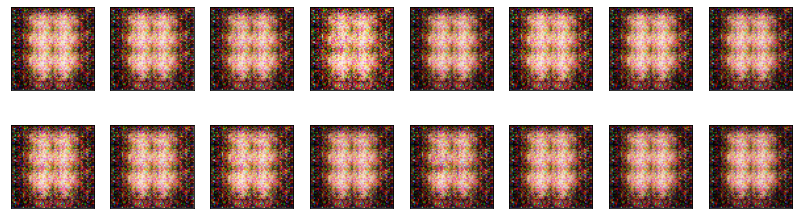

2024-10-15 20:08:45 | Epoch [2/25] | Batch 0/509 | d_loss: 0.4686 | g_loss: -0.0599
2024-10-15 20:09:21 | Epoch [2/25] | Batch 50/509 | d_loss: 0.1853 | g_loss: -0.0278
2024-10-15 20:09:56 | Epoch [2/25] | Batch 100/509 | d_loss: -0.0082 | g_loss: -0.0232
2024-10-15 20:10:32 | Epoch [2/25] | Batch 150/509 | d_loss: -0.4194 | g_loss: -0.0172
2024-10-15 20:11:07 | Epoch [2/25] | Batch 200/509 | d_loss: 0.0492 | g_loss: -0.0324
2024-10-15 20:11:43 | Epoch [2/25] | Batch 250/509 | d_loss: 0.7619 | g_loss: -0.0753
2024-10-15 20:12:18 | Epoch [2/25] | Batch 300/509 | d_loss: 0.2232 | g_loss: -0.0379
2024-10-15 20:12:54 | Epoch [2/25] | Batch 350/509 | d_loss: -0.4560 | g_loss: -0.0762
2024-10-15 20:13:29 | Epoch [2/25] | Batch 400/509 | d_loss: 0.1158 | g_loss: -0.3348
2024-10-15 20:14:05 | Epoch [2/25] | Batch 450/509 | d_loss: 0.1988 | g_loss: -0.0710
2024-10-15 20:14:40 | Epoch [2/25] | Batch 500/509 | d_loss: 1.6577 | g_loss: -0.3738


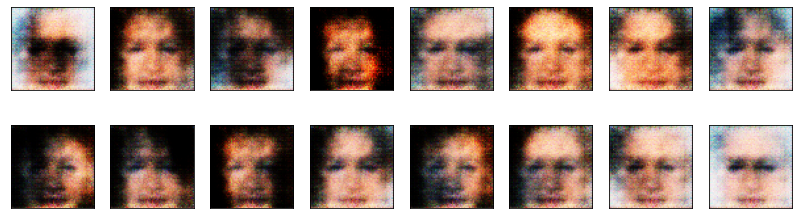

2024-10-15 20:14:50 | Epoch [3/25] | Batch 0/509 | d_loss: 1.1460 | g_loss: -0.4310
2024-10-15 20:15:25 | Epoch [3/25] | Batch 50/509 | d_loss: -0.5495 | g_loss: -0.1550
2024-10-15 20:16:01 | Epoch [3/25] | Batch 100/509 | d_loss: -0.4391 | g_loss: -0.1779
2024-10-15 20:16:36 | Epoch [3/25] | Batch 150/509 | d_loss: -0.5726 | g_loss: -0.1872
2024-10-15 20:17:12 | Epoch [3/25] | Batch 200/509 | d_loss: -0.4027 | g_loss: -0.1039
2024-10-15 20:17:47 | Epoch [3/25] | Batch 250/509 | d_loss: -0.4490 | g_loss: -0.1452
2024-10-15 20:18:23 | Epoch [3/25] | Batch 300/509 | d_loss: -0.1834 | g_loss: -0.3249
2024-10-15 20:18:58 | Epoch [3/25] | Batch 350/509 | d_loss: -0.3242 | g_loss: -0.2465
2024-10-15 20:19:34 | Epoch [3/25] | Batch 400/509 | d_loss: -0.0968 | g_loss: -0.6394
2024-10-15 20:20:09 | Epoch [3/25] | Batch 450/509 | d_loss: -0.4854 | g_loss: -0.2380
2024-10-15 20:20:45 | Epoch [3/25] | Batch 500/509 | d_loss: 0.0629 | g_loss: -0.4437


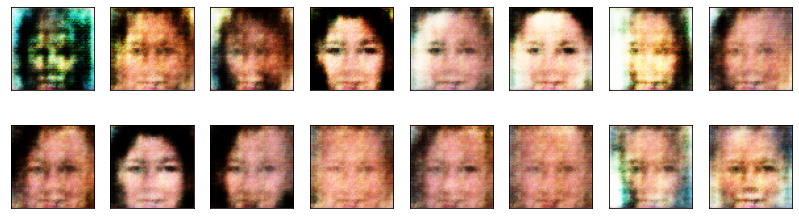

2024-10-15 20:20:56 | Epoch [4/25] | Batch 0/509 | d_loss: -0.6046 | g_loss: -0.1746
2024-10-15 20:21:31 | Epoch [4/25] | Batch 50/509 | d_loss: -0.5296 | g_loss: -0.1495
2024-10-15 20:22:07 | Epoch [4/25] | Batch 100/509 | d_loss: -0.6229 | g_loss: -0.1730
2024-10-15 20:22:42 | Epoch [4/25] | Batch 150/509 | d_loss: -0.3948 | g_loss: -0.2097
2024-10-15 20:23:18 | Epoch [4/25] | Batch 200/509 | d_loss: -0.3953 | g_loss: -0.1662
2024-10-15 20:23:53 | Epoch [4/25] | Batch 250/509 | d_loss: -0.5573 | g_loss: -0.1295
2024-10-15 20:24:29 | Epoch [4/25] | Batch 300/509 | d_loss: -0.6317 | g_loss: -0.1571
2024-10-15 20:25:05 | Epoch [4/25] | Batch 350/509 | d_loss: -0.2853 | g_loss: -0.1929
2024-10-15 20:25:40 | Epoch [4/25] | Batch 400/509 | d_loss: -0.4911 | g_loss: -0.3902
2024-10-15 20:26:16 | Epoch [4/25] | Batch 450/509 | d_loss: -0.5767 | g_loss: -0.1308
2024-10-15 20:26:51 | Epoch [4/25] | Batch 500/509 | d_loss: -0.2542 | g_loss: -0.4056


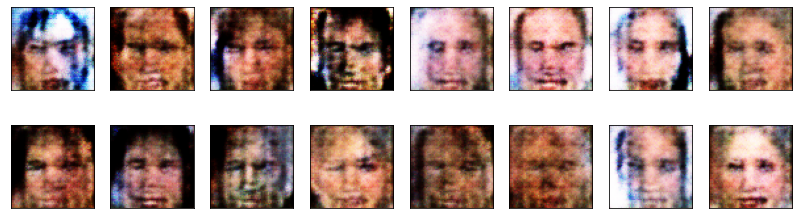

2024-10-15 20:27:02 | Epoch [5/25] | Batch 0/509 | d_loss: 0.3703 | g_loss: -0.6477
2024-10-15 20:27:38 | Epoch [5/25] | Batch 50/509 | d_loss: -0.1418 | g_loss: -0.4587
2024-10-15 20:28:13 | Epoch [5/25] | Batch 100/509 | d_loss: -0.3792 | g_loss: -0.2454
2024-10-15 20:28:49 | Epoch [5/25] | Batch 150/509 | d_loss: -0.4870 | g_loss: -0.2691
2024-10-15 20:29:24 | Epoch [5/25] | Batch 200/509 | d_loss: -0.4719 | g_loss: -0.3133
2024-10-15 20:30:00 | Epoch [5/25] | Batch 250/509 | d_loss: -0.3817 | g_loss: -0.4587
2024-10-15 20:30:36 | Epoch [5/25] | Batch 300/509 | d_loss: -0.5639 | g_loss: -0.1984
2024-10-15 20:31:11 | Epoch [5/25] | Batch 350/509 | d_loss: -0.6292 | g_loss: -0.1667
2024-10-15 20:31:47 | Epoch [5/25] | Batch 400/509 | d_loss: -0.4797 | g_loss: -0.1540
2024-10-15 20:32:22 | Epoch [5/25] | Batch 450/509 | d_loss: -0.5949 | g_loss: -0.2428
2024-10-15 20:32:58 | Epoch [5/25] | Batch 500/509 | d_loss: -0.6465 | g_loss: -0.1290


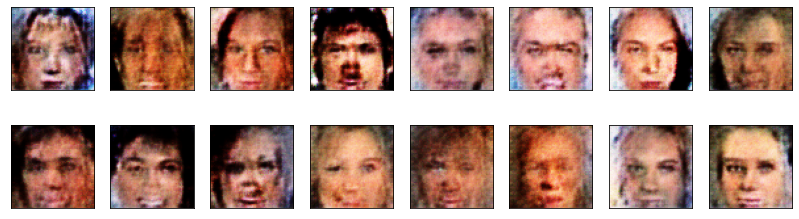

2024-10-15 20:33:08 | Epoch [6/25] | Batch 0/509 | d_loss: -0.5250 | g_loss: -0.1456
2024-10-15 20:33:44 | Epoch [6/25] | Batch 50/509 | d_loss: -0.6813 | g_loss: -0.1438
2024-10-15 20:34:19 | Epoch [6/25] | Batch 100/509 | d_loss: -0.4959 | g_loss: -0.2232
2024-10-15 20:34:55 | Epoch [6/25] | Batch 150/509 | d_loss: -0.6594 | g_loss: -0.2052
2024-10-15 20:35:30 | Epoch [6/25] | Batch 200/509 | d_loss: -0.6417 | g_loss: -0.2327
2024-10-15 20:36:06 | Epoch [6/25] | Batch 250/509 | d_loss: -0.5186 | g_loss: -0.1536
2024-10-15 20:36:41 | Epoch [6/25] | Batch 300/509 | d_loss: -0.5214 | g_loss: -0.2206
2024-10-15 20:37:17 | Epoch [6/25] | Batch 350/509 | d_loss: -0.5552 | g_loss: -0.2683
2024-10-15 20:37:52 | Epoch [6/25] | Batch 400/509 | d_loss: -0.5947 | g_loss: -0.1758
2024-10-15 20:38:28 | Epoch [6/25] | Batch 450/509 | d_loss: -0.6168 | g_loss: -0.1351
2024-10-15 20:39:03 | Epoch [6/25] | Batch 500/509 | d_loss: -0.6305 | g_loss: -0.2037


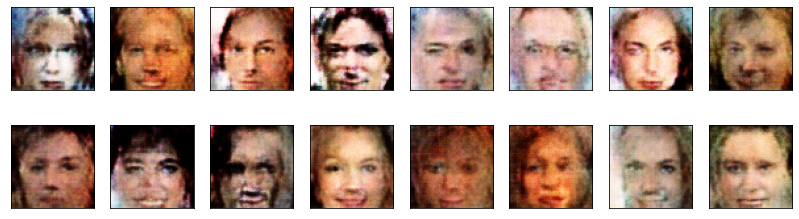

2024-10-15 20:39:13 | Epoch [7/25] | Batch 0/509 | d_loss: -0.6548 | g_loss: -0.1962
2024-10-15 20:39:49 | Epoch [7/25] | Batch 50/509 | d_loss: -0.6241 | g_loss: -0.1926
2024-10-15 20:40:24 | Epoch [7/25] | Batch 100/509 | d_loss: -0.5385 | g_loss: -0.3236
2024-10-15 20:41:00 | Epoch [7/25] | Batch 150/509 | d_loss: -0.6107 | g_loss: -0.1489
2024-10-15 20:41:35 | Epoch [7/25] | Batch 200/509 | d_loss: -0.6021 | g_loss: -0.1702
2024-10-15 20:42:11 | Epoch [7/25] | Batch 250/509 | d_loss: -0.5677 | g_loss: -0.1949
2024-10-15 20:42:47 | Epoch [7/25] | Batch 300/509 | d_loss: 0.1793 | g_loss: -0.2984
2024-10-15 20:43:22 | Epoch [7/25] | Batch 350/509 | d_loss: -0.6246 | g_loss: -0.2486
2024-10-15 20:43:58 | Epoch [7/25] | Batch 400/509 | d_loss: -0.5586 | g_loss: -0.1492
2024-10-15 20:44:33 | Epoch [7/25] | Batch 450/509 | d_loss: -0.6546 | g_loss: -0.1839
2024-10-15 20:45:09 | Epoch [7/25] | Batch 500/509 | d_loss: -0.2008 | g_loss: -0.3525


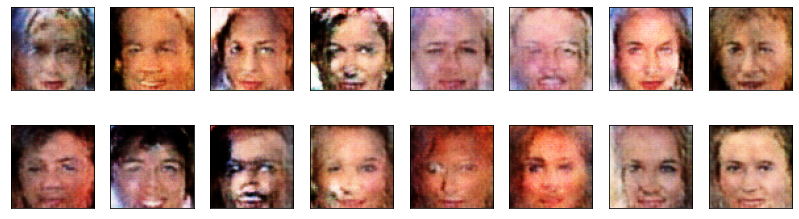

2024-10-15 20:45:19 | Epoch [8/25] | Batch 0/509 | d_loss: -0.6154 | g_loss: -0.1670
2024-10-15 20:45:55 | Epoch [8/25] | Batch 50/509 | d_loss: -0.6755 | g_loss: -0.1638
2024-10-15 20:46:30 | Epoch [8/25] | Batch 100/509 | d_loss: -0.6497 | g_loss: -0.1540
2024-10-15 20:47:06 | Epoch [8/25] | Batch 150/509 | d_loss: -0.5625 | g_loss: -0.2374
2024-10-15 20:47:41 | Epoch [8/25] | Batch 200/509 | d_loss: 0.2487 | g_loss: -0.0682
2024-10-15 20:48:17 | Epoch [8/25] | Batch 250/509 | d_loss: -0.5518 | g_loss: -0.1824
2024-10-15 20:48:52 | Epoch [8/25] | Batch 300/509 | d_loss: -0.6612 | g_loss: -0.1408
2024-10-15 20:49:28 | Epoch [8/25] | Batch 350/509 | d_loss: -0.6556 | g_loss: -0.1093
2024-10-15 20:50:03 | Epoch [8/25] | Batch 400/509 | d_loss: -0.5962 | g_loss: -0.2093
2024-10-15 20:50:39 | Epoch [8/25] | Batch 450/509 | d_loss: -0.6879 | g_loss: -0.1342
2024-10-15 20:51:14 | Epoch [8/25] | Batch 500/509 | d_loss: -0.7321 | g_loss: -0.1254


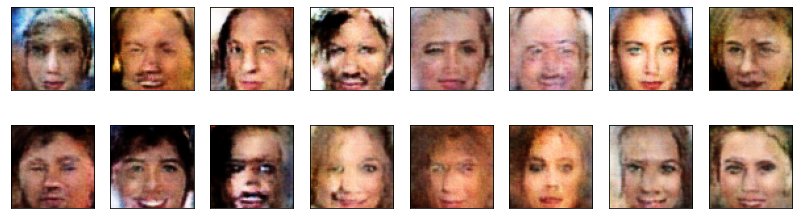

2024-10-15 20:51:24 | Epoch [9/25] | Batch 0/509 | d_loss: -0.7398 | g_loss: -0.1337
2024-10-15 20:51:59 | Epoch [9/25] | Batch 50/509 | d_loss: -0.5435 | g_loss: -0.1226
2024-10-15 20:52:35 | Epoch [9/25] | Batch 100/509 | d_loss: -0.7000 | g_loss: -0.0999
2024-10-15 20:53:10 | Epoch [9/25] | Batch 150/509 | d_loss: -0.5220 | g_loss: -0.3604
2024-10-15 20:53:46 | Epoch [9/25] | Batch 200/509 | d_loss: -0.6758 | g_loss: -0.1170
2024-10-15 20:54:21 | Epoch [9/25] | Batch 250/509 | d_loss: -0.6591 | g_loss: -0.1366
2024-10-15 20:54:57 | Epoch [9/25] | Batch 300/509 | d_loss: -0.7137 | g_loss: -0.0991
2024-10-15 20:55:33 | Epoch [9/25] | Batch 350/509 | d_loss: -0.6954 | g_loss: -0.1489
2024-10-15 20:56:08 | Epoch [9/25] | Batch 400/509 | d_loss: -0.0551 | g_loss: -0.1613
2024-10-15 20:56:44 | Epoch [9/25] | Batch 450/509 | d_loss: -0.6048 | g_loss: -0.0828
2024-10-15 20:57:19 | Epoch [9/25] | Batch 500/509 | d_loss: -0.6668 | g_loss: -0.1147


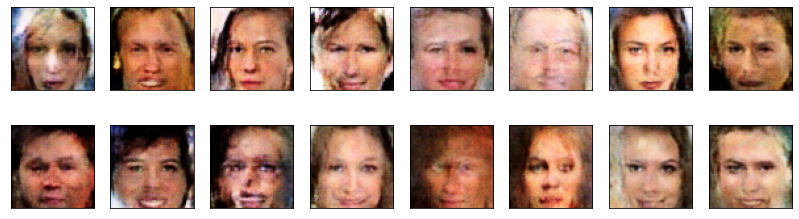

2024-10-15 20:57:30 | Epoch [10/25] | Batch 0/509 | d_loss: -0.3411 | g_loss: -0.2182
2024-10-15 20:58:05 | Epoch [10/25] | Batch 50/509 | d_loss: -0.7156 | g_loss: -0.1342
2024-10-15 20:58:41 | Epoch [10/25] | Batch 100/509 | d_loss: -0.6567 | g_loss: -0.1417
2024-10-15 20:59:16 | Epoch [10/25] | Batch 150/509 | d_loss: -0.4441 | g_loss: -0.1722
2024-10-15 20:59:52 | Epoch [10/25] | Batch 200/509 | d_loss: -0.7354 | g_loss: -0.1492
2024-10-15 21:00:27 | Epoch [10/25] | Batch 250/509 | d_loss: -0.6611 | g_loss: -0.0923
2024-10-15 21:01:03 | Epoch [10/25] | Batch 300/509 | d_loss: -0.2117 | g_loss: -0.2086
2024-10-15 21:01:38 | Epoch [10/25] | Batch 350/509 | d_loss: -0.7894 | g_loss: -0.0883
2024-10-15 21:02:14 | Epoch [10/25] | Batch 400/509 | d_loss: -0.6478 | g_loss: -0.1509
2024-10-15 21:02:50 | Epoch [10/25] | Batch 450/509 | d_loss: -0.7496 | g_loss: -0.1125
2024-10-15 21:03:25 | Epoch [10/25] | Batch 500/509 | d_loss: -0.7169 | g_loss: -0.1438


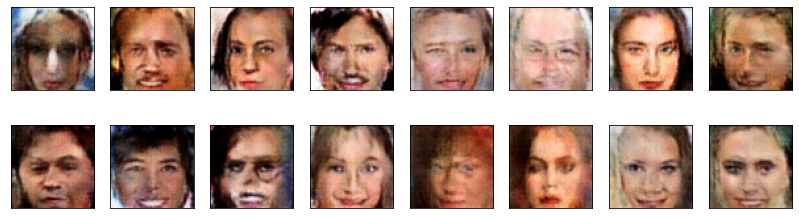

2024-10-15 21:03:35 | Epoch [11/25] | Batch 0/509 | d_loss: -0.6697 | g_loss: -0.1615
2024-10-15 21:04:11 | Epoch [11/25] | Batch 50/509 | d_loss: -0.6532 | g_loss: -0.0968
2024-10-15 21:04:46 | Epoch [11/25] | Batch 100/509 | d_loss: -0.7991 | g_loss: -0.0699
2024-10-15 21:05:22 | Epoch [11/25] | Batch 150/509 | d_loss: -0.5832 | g_loss: -0.2302
2024-10-15 21:05:58 | Epoch [11/25] | Batch 200/509 | d_loss: -0.6804 | g_loss: -0.1082
2024-10-15 21:06:33 | Epoch [11/25] | Batch 250/509 | d_loss: -0.6186 | g_loss: -0.1880
2024-10-15 21:07:09 | Epoch [11/25] | Batch 300/509 | d_loss: -0.6638 | g_loss: -0.0891
2024-10-15 21:07:44 | Epoch [11/25] | Batch 350/509 | d_loss: -0.7177 | g_loss: -0.1814
2024-10-15 21:08:20 | Epoch [11/25] | Batch 400/509 | d_loss: -0.7281 | g_loss: -0.1041
2024-10-15 21:08:55 | Epoch [11/25] | Batch 450/509 | d_loss: -0.7701 | g_loss: -0.1008
2024-10-15 21:09:31 | Epoch [11/25] | Batch 500/509 | d_loss: -0.7276 | g_loss: -0.0775


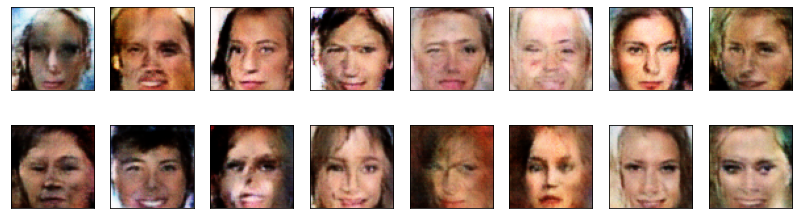

2024-10-15 21:09:41 | Epoch [12/25] | Batch 0/509 | d_loss: -0.4775 | g_loss: -0.1477
2024-10-15 21:10:16 | Epoch [12/25] | Batch 50/509 | d_loss: -0.5289 | g_loss: -0.3178
2024-10-15 21:10:52 | Epoch [12/25] | Batch 100/509 | d_loss: -0.4191 | g_loss: -0.1822
2024-10-15 21:11:27 | Epoch [12/25] | Batch 150/509 | d_loss: -0.6581 | g_loss: -0.2053
2024-10-15 21:12:03 | Epoch [12/25] | Batch 200/509 | d_loss: -0.5760 | g_loss: -0.2215
2024-10-15 21:12:38 | Epoch [12/25] | Batch 250/509 | d_loss: -0.7139 | g_loss: -0.2002
2024-10-15 21:13:14 | Epoch [12/25] | Batch 300/509 | d_loss: -0.3060 | g_loss: -0.2516
2024-10-15 21:13:49 | Epoch [12/25] | Batch 350/509 | d_loss: -0.7720 | g_loss: -0.0742
2024-10-15 21:14:25 | Epoch [12/25] | Batch 400/509 | d_loss: -0.6465 | g_loss: -0.1431
2024-10-15 21:15:00 | Epoch [12/25] | Batch 450/509 | d_loss: -0.1914 | g_loss: -0.2938
2024-10-15 21:15:36 | Epoch [12/25] | Batch 500/509 | d_loss: 0.0476 | g_loss: -0.3411


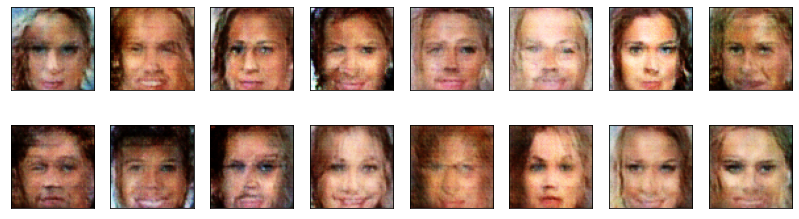

2024-10-15 21:15:46 | Epoch [13/25] | Batch 0/509 | d_loss: -0.6990 | g_loss: -0.1747
2024-10-15 21:16:21 | Epoch [13/25] | Batch 50/509 | d_loss: -0.5633 | g_loss: -0.1585
2024-10-15 21:16:57 | Epoch [13/25] | Batch 100/509 | d_loss: -0.6240 | g_loss: -0.2483
2024-10-15 21:17:32 | Epoch [13/25] | Batch 150/509 | d_loss: -0.6837 | g_loss: -0.1729
2024-10-15 21:18:07 | Epoch [13/25] | Batch 200/509 | d_loss: -0.6953 | g_loss: -0.2502
2024-10-15 21:18:43 | Epoch [13/25] | Batch 250/509 | d_loss: -0.6816 | g_loss: -0.1340
2024-10-15 21:19:19 | Epoch [13/25] | Batch 300/509 | d_loss: -0.7303 | g_loss: -0.1178
2024-10-15 21:19:54 | Epoch [13/25] | Batch 350/509 | d_loss: -0.7382 | g_loss: -0.0962
2024-10-15 21:20:30 | Epoch [13/25] | Batch 400/509 | d_loss: -0.2272 | g_loss: -0.1025
2024-10-15 21:21:05 | Epoch [13/25] | Batch 450/509 | d_loss: -0.6877 | g_loss: -0.0990
2024-10-15 21:21:41 | Epoch [13/25] | Batch 500/509 | d_loss: -0.2453 | g_loss: -0.1226


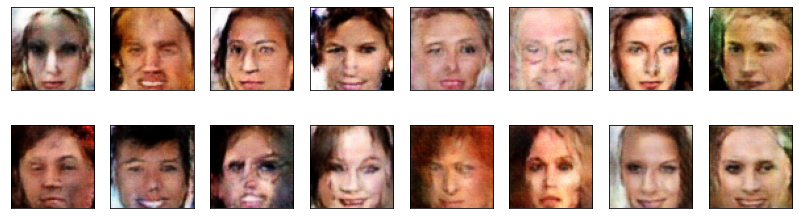

2024-10-15 21:21:51 | Epoch [14/25] | Batch 0/509 | d_loss: -0.7167 | g_loss: -0.0591
2024-10-15 21:22:27 | Epoch [14/25] | Batch 50/509 | d_loss: -0.4357 | g_loss: -0.2079
2024-10-15 21:23:02 | Epoch [14/25] | Batch 100/509 | d_loss: -0.6953 | g_loss: -0.1481
2024-10-15 21:23:38 | Epoch [14/25] | Batch 150/509 | d_loss: -0.7758 | g_loss: -0.1311
2024-10-15 21:24:13 | Epoch [14/25] | Batch 200/509 | d_loss: -0.7385 | g_loss: -0.1540
2024-10-15 21:24:48 | Epoch [14/25] | Batch 250/509 | d_loss: -0.7137 | g_loss: -0.1207
2024-10-15 21:25:24 | Epoch [14/25] | Batch 300/509 | d_loss: -0.7975 | g_loss: -0.0488
2024-10-15 21:25:59 | Epoch [14/25] | Batch 350/509 | d_loss: -0.8029 | g_loss: -0.1020
2024-10-15 21:26:35 | Epoch [14/25] | Batch 400/509 | d_loss: -0.7925 | g_loss: -0.0547
2024-10-15 21:27:11 | Epoch [14/25] | Batch 450/509 | d_loss: -0.6893 | g_loss: -0.2100
2024-10-15 21:27:46 | Epoch [14/25] | Batch 500/509 | d_loss: -0.5624 | g_loss: -0.0958


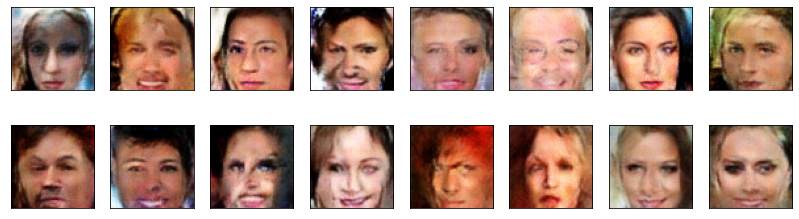

2024-10-15 21:27:56 | Epoch [15/25] | Batch 0/509 | d_loss: -0.6293 | g_loss: -0.0240
2024-10-15 21:28:32 | Epoch [15/25] | Batch 50/509 | d_loss: -0.7188 | g_loss: -0.2669
2024-10-15 21:29:07 | Epoch [15/25] | Batch 100/509 | d_loss: -0.3790 | g_loss: -0.4732
2024-10-15 21:29:43 | Epoch [15/25] | Batch 150/509 | d_loss: -0.5629 | g_loss: -0.4808
2024-10-15 21:30:18 | Epoch [15/25] | Batch 200/509 | d_loss: -0.7366 | g_loss: -0.1708
2024-10-15 21:30:54 | Epoch [15/25] | Batch 250/509 | d_loss: -0.3963 | g_loss: -0.4256
2024-10-15 21:31:29 | Epoch [15/25] | Batch 300/509 | d_loss: -0.2561 | g_loss: -0.4131
2024-10-15 21:32:05 | Epoch [15/25] | Batch 350/509 | d_loss: -0.5085 | g_loss: -0.3309
2024-10-15 21:32:40 | Epoch [15/25] | Batch 400/509 | d_loss: -0.3265 | g_loss: -0.4154
2024-10-15 21:33:16 | Epoch [15/25] | Batch 450/509 | d_loss: -0.6375 | g_loss: -0.2500
2024-10-15 21:33:51 | Epoch [15/25] | Batch 500/509 | d_loss: -0.6895 | g_loss: -0.2274


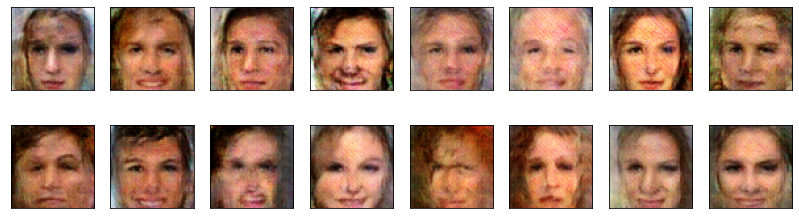

2024-10-15 21:34:01 | Epoch [16/25] | Batch 0/509 | d_loss: -0.7470 | g_loss: -0.1704
2024-10-15 21:34:36 | Epoch [16/25] | Batch 50/509 | d_loss: -0.6312 | g_loss: -0.2521
2024-10-15 21:35:12 | Epoch [16/25] | Batch 100/509 | d_loss: -0.7212 | g_loss: -0.1969
2024-10-15 21:35:47 | Epoch [16/25] | Batch 150/509 | d_loss: -0.5192 | g_loss: -0.4085
2024-10-15 21:36:23 | Epoch [16/25] | Batch 200/509 | d_loss: -0.6217 | g_loss: -0.4091
2024-10-15 21:36:58 | Epoch [16/25] | Batch 250/509 | d_loss: -0.6184 | g_loss: -0.3191
2024-10-15 21:37:34 | Epoch [16/25] | Batch 300/509 | d_loss: -0.6938 | g_loss: -0.2427
2024-10-15 21:38:09 | Epoch [16/25] | Batch 350/509 | d_loss: -0.7084 | g_loss: -0.2277
2024-10-15 21:38:45 | Epoch [16/25] | Batch 400/509 | d_loss: -0.6379 | g_loss: -0.2570
2024-10-15 21:39:20 | Epoch [16/25] | Batch 450/509 | d_loss: -0.6799 | g_loss: -0.2041
2024-10-15 21:39:56 | Epoch [16/25] | Batch 500/509 | d_loss: -0.6541 | g_loss: -0.2563


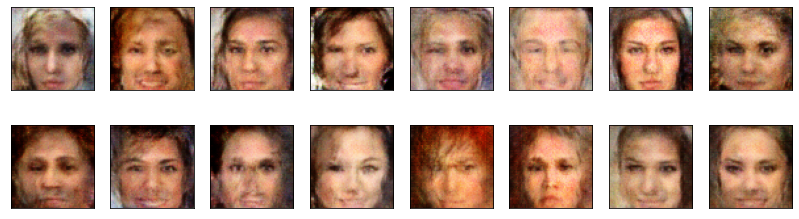

2024-10-15 21:40:06 | Epoch [17/25] | Batch 0/509 | d_loss: -0.6807 | g_loss: -0.2460
2024-10-15 21:40:42 | Epoch [17/25] | Batch 50/509 | d_loss: -0.7873 | g_loss: -0.1449
2024-10-15 21:41:18 | Epoch [17/25] | Batch 100/509 | d_loss: -0.6276 | g_loss: -0.3191
2024-10-15 21:41:53 | Epoch [17/25] | Batch 150/509 | d_loss: -0.3208 | g_loss: -0.3185
2024-10-15 21:42:28 | Epoch [17/25] | Batch 200/509 | d_loss: -0.7698 | g_loss: -0.1638
2024-10-15 21:43:04 | Epoch [17/25] | Batch 250/509 | d_loss: -0.7211 | g_loss: -0.2020
2024-10-15 21:43:39 | Epoch [17/25] | Batch 300/509 | d_loss: -0.0155 | g_loss: -0.5606
2024-10-15 21:44:15 | Epoch [17/25] | Batch 350/509 | d_loss: -0.4416 | g_loss: -0.2240
2024-10-15 21:44:50 | Epoch [17/25] | Batch 400/509 | d_loss: -0.6885 | g_loss: -0.1568
2024-10-15 21:45:26 | Epoch [17/25] | Batch 450/509 | d_loss: -0.7472 | g_loss: -0.0546
2024-10-15 21:46:01 | Epoch [17/25] | Batch 500/509 | d_loss: -0.4037 | g_loss: -0.4542


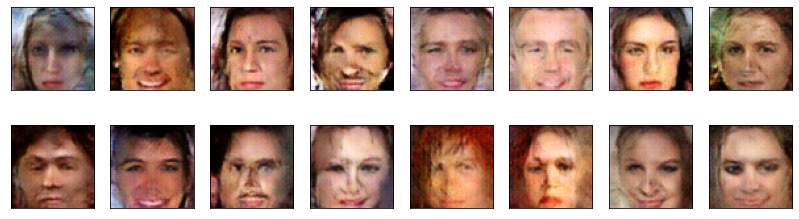

2024-10-15 21:46:12 | Epoch [18/25] | Batch 0/509 | d_loss: -0.7466 | g_loss: -0.1347
2024-10-15 21:46:49 | Epoch [18/25] | Batch 50/509 | d_loss: 0.3293 | g_loss: -0.5429
2024-10-15 21:47:24 | Epoch [18/25] | Batch 100/509 | d_loss: -0.7575 | g_loss: -0.1450
2024-10-15 21:48:00 | Epoch [18/25] | Batch 150/509 | d_loss: -0.6545 | g_loss: -0.3379
2024-10-15 21:48:35 | Epoch [18/25] | Batch 200/509 | d_loss: -0.3037 | g_loss: -0.2525
2024-10-15 21:49:11 | Epoch [18/25] | Batch 250/509 | d_loss: -0.6162 | g_loss: -0.3405
2024-10-15 21:49:46 | Epoch [18/25] | Batch 300/509 | d_loss: -0.6506 | g_loss: -0.1837
2024-10-15 21:50:22 | Epoch [18/25] | Batch 350/509 | d_loss: -0.6779 | g_loss: -0.2751
2024-10-15 21:50:57 | Epoch [18/25] | Batch 400/509 | d_loss: -0.6224 | g_loss: -0.2512
2024-10-15 21:51:33 | Epoch [18/25] | Batch 450/509 | d_loss: -0.6196 | g_loss: -0.2369
2024-10-15 21:52:09 | Epoch [18/25] | Batch 500/509 | d_loss: -0.7030 | g_loss: -0.1858


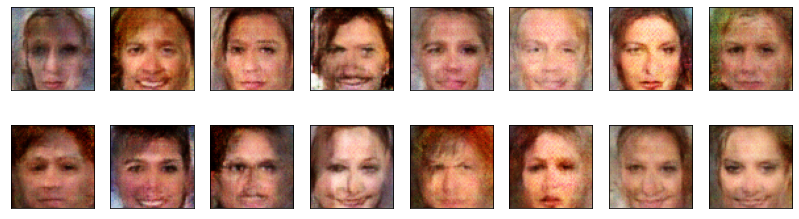

2024-10-15 21:52:19 | Epoch [19/25] | Batch 0/509 | d_loss: -0.7433 | g_loss: -0.2179
2024-10-15 21:52:54 | Epoch [19/25] | Batch 50/509 | d_loss: -0.6291 | g_loss: -0.2381
2024-10-15 21:53:30 | Epoch [19/25] | Batch 100/509 | d_loss: -0.4418 | g_loss: -0.0640
2024-10-15 21:54:05 | Epoch [19/25] | Batch 150/509 | d_loss: -0.6847 | g_loss: -0.1800
2024-10-15 21:54:41 | Epoch [19/25] | Batch 200/509 | d_loss: -0.7581 | g_loss: -0.1107
2024-10-15 21:55:16 | Epoch [19/25] | Batch 250/509 | d_loss: -0.7315 | g_loss: -0.0625
2024-10-15 21:55:52 | Epoch [19/25] | Batch 300/509 | d_loss: -0.3834 | g_loss: -0.1083
2024-10-15 21:56:27 | Epoch [19/25] | Batch 350/509 | d_loss: -0.7066 | g_loss: -0.1543
2024-10-15 21:57:03 | Epoch [19/25] | Batch 400/509 | d_loss: -0.6969 | g_loss: -0.2305
2024-10-15 21:57:38 | Epoch [19/25] | Batch 450/509 | d_loss: -0.6930 | g_loss: -0.2487
2024-10-15 21:58:14 | Epoch [19/25] | Batch 500/509 | d_loss: -0.7112 | g_loss: -0.2109


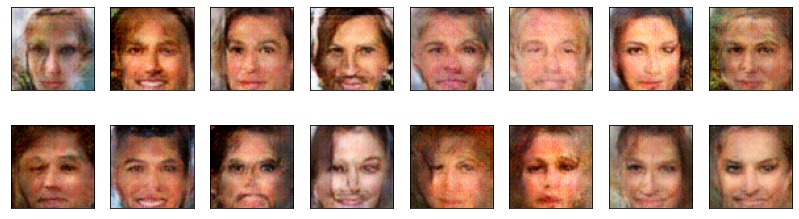

2024-10-15 21:58:23 | Epoch [20/25] | Batch 0/509 | d_loss: -0.6158 | g_loss: -0.3045
2024-10-15 21:58:59 | Epoch [20/25] | Batch 50/509 | d_loss: -0.4865 | g_loss: -0.2156
2024-10-15 21:59:34 | Epoch [20/25] | Batch 100/509 | d_loss: -0.5741 | g_loss: -0.1741
2024-10-15 22:00:10 | Epoch [20/25] | Batch 150/509 | d_loss: -0.0413 | g_loss: -0.5091
2024-10-15 22:00:45 | Epoch [20/25] | Batch 200/509 | d_loss: -0.4244 | g_loss: -0.1984
2024-10-15 22:01:21 | Epoch [20/25] | Batch 250/509 | d_loss: -0.6390 | g_loss: -0.2849
2024-10-15 22:01:56 | Epoch [20/25] | Batch 300/509 | d_loss: 3.7166 | g_loss: -0.6238
2024-10-15 22:02:32 | Epoch [20/25] | Batch 350/509 | d_loss: -0.7076 | g_loss: -0.1455
2024-10-15 22:03:07 | Epoch [20/25] | Batch 400/509 | d_loss: -0.5045 | g_loss: -0.2217
2024-10-15 22:03:43 | Epoch [20/25] | Batch 450/509 | d_loss: -0.7096 | g_loss: -0.2461
2024-10-15 22:04:19 | Epoch [20/25] | Batch 500/509 | d_loss: -0.7437 | g_loss: -0.1294


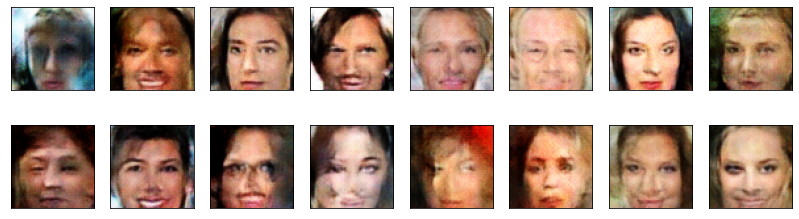

2024-10-15 22:04:29 | Epoch [21/25] | Batch 0/509 | d_loss: -0.5740 | g_loss: -0.0726
2024-10-15 22:05:04 | Epoch [21/25] | Batch 50/509 | d_loss: -0.8007 | g_loss: -0.0814
2024-10-15 22:05:40 | Epoch [21/25] | Batch 100/509 | d_loss: 0.0237 | g_loss: -0.4670
2024-10-15 22:06:15 | Epoch [21/25] | Batch 150/509 | d_loss: -0.7157 | g_loss: -0.2123
2024-10-15 22:06:51 | Epoch [21/25] | Batch 200/509 | d_loss: -0.6108 | g_loss: -0.2959
2024-10-15 22:07:26 | Epoch [21/25] | Batch 250/509 | d_loss: -0.6639 | g_loss: -0.2930
2024-10-15 22:08:02 | Epoch [21/25] | Batch 300/509 | d_loss: -0.7553 | g_loss: -0.1803
2024-10-15 22:08:37 | Epoch [21/25] | Batch 350/509 | d_loss: -0.6515 | g_loss: -0.2169
2024-10-15 22:09:13 | Epoch [21/25] | Batch 400/509 | d_loss: -0.6426 | g_loss: -0.2495
2024-10-15 22:09:48 | Epoch [21/25] | Batch 450/509 | d_loss: -0.3318 | g_loss: -0.2941
2024-10-15 22:10:24 | Epoch [21/25] | Batch 500/509 | d_loss: -0.6660 | g_loss: -0.1542


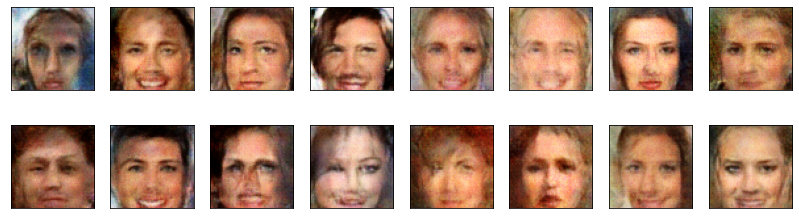

2024-10-15 22:10:34 | Epoch [22/25] | Batch 0/509 | d_loss: -0.7677 | g_loss: -0.1527
2024-10-15 22:11:10 | Epoch [22/25] | Batch 50/509 | d_loss: -0.7468 | g_loss: -0.1062
2024-10-15 22:11:45 | Epoch [22/25] | Batch 100/509 | d_loss: -0.6588 | g_loss: -0.2303
2024-10-15 22:12:21 | Epoch [22/25] | Batch 150/509 | d_loss: -0.6926 | g_loss: -0.2785
2024-10-15 22:12:56 | Epoch [22/25] | Batch 200/509 | d_loss: -0.6922 | g_loss: -0.2306
2024-10-15 22:13:32 | Epoch [22/25] | Batch 250/509 | d_loss: -0.6069 | g_loss: -0.2731
2024-10-15 22:14:07 | Epoch [22/25] | Batch 300/509 | d_loss: -0.6144 | g_loss: -0.2553
2024-10-15 22:14:43 | Epoch [22/25] | Batch 350/509 | d_loss: -0.7512 | g_loss: -0.1800
2024-10-15 22:15:18 | Epoch [22/25] | Batch 400/509 | d_loss: -0.7105 | g_loss: -0.1435
2024-10-15 22:15:54 | Epoch [22/25] | Batch 450/509 | d_loss: -0.7465 | g_loss: -0.2137
2024-10-15 22:16:29 | Epoch [22/25] | Batch 500/509 | d_loss: -0.7885 | g_loss: -0.1908


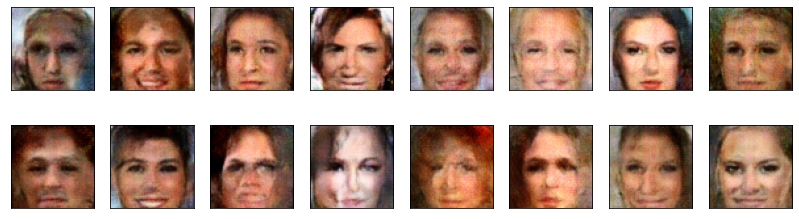

2024-10-15 22:16:39 | Epoch [23/25] | Batch 0/509 | d_loss: -0.6115 | g_loss: -0.2330
2024-10-15 22:17:14 | Epoch [23/25] | Batch 50/509 | d_loss: -0.5236 | g_loss: -0.2889
2024-10-15 22:17:50 | Epoch [23/25] | Batch 100/509 | d_loss: -0.4767 | g_loss: -0.3565
2024-10-15 22:18:25 | Epoch [23/25] | Batch 150/509 | d_loss: -0.7569 | g_loss: -0.1575
2024-10-15 22:19:01 | Epoch [23/25] | Batch 200/509 | d_loss: -0.2838 | g_loss: -0.2373
2024-10-15 22:19:36 | Epoch [23/25] | Batch 250/509 | d_loss: -0.5389 | g_loss: -0.2615
2024-10-15 22:20:12 | Epoch [23/25] | Batch 300/509 | d_loss: -0.7446 | g_loss: -0.0648
2024-10-15 22:20:47 | Epoch [23/25] | Batch 350/509 | d_loss: -0.6355 | g_loss: -0.1364
2024-10-15 22:21:23 | Epoch [23/25] | Batch 400/509 | d_loss: -0.6145 | g_loss: -0.1175
2024-10-15 22:21:58 | Epoch [23/25] | Batch 450/509 | d_loss: -0.5290 | g_loss: -0.1282
2024-10-15 22:22:34 | Epoch [23/25] | Batch 500/509 | d_loss: 0.0635 | g_loss: -0.6288


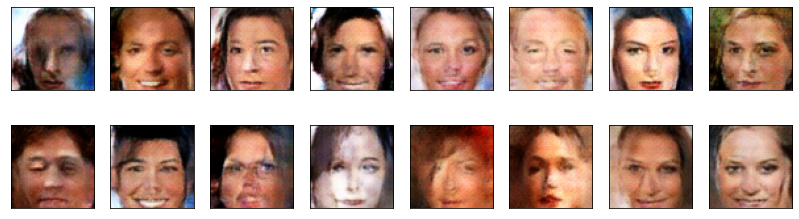

2024-10-15 22:22:43 | Epoch [24/25] | Batch 0/509 | d_loss: -0.4825 | g_loss: -0.0874
2024-10-15 22:23:19 | Epoch [24/25] | Batch 50/509 | d_loss: -0.2992 | g_loss: -0.3420
2024-10-15 22:23:55 | Epoch [24/25] | Batch 100/509 | d_loss: -0.6274 | g_loss: -0.1005
2024-10-15 22:24:30 | Epoch [24/25] | Batch 150/509 | d_loss: -0.6943 | g_loss: -0.1123
2024-10-15 22:25:05 | Epoch [24/25] | Batch 200/509 | d_loss: -0.6865 | g_loss: -0.1975
2024-10-15 22:25:41 | Epoch [24/25] | Batch 250/509 | d_loss: -0.6791 | g_loss: -0.1370
2024-10-15 22:26:17 | Epoch [24/25] | Batch 300/509 | d_loss: -0.2713 | g_loss: -0.3289
2024-10-15 22:26:52 | Epoch [24/25] | Batch 350/509 | d_loss: -0.1710 | g_loss: -0.7053
2024-10-15 22:27:28 | Epoch [24/25] | Batch 400/509 | d_loss: -0.7086 | g_loss: -0.1880
2024-10-15 22:28:03 | Epoch [24/25] | Batch 450/509 | d_loss: -0.6978 | g_loss: -0.2988
2024-10-15 22:28:38 | Epoch [24/25] | Batch 500/509 | d_loss: -0.7024 | g_loss: -0.2250


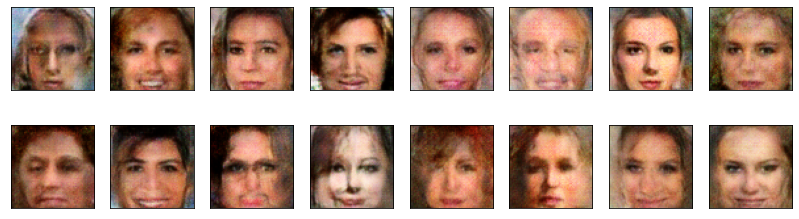

2024-10-15 22:28:48 | Epoch [25/25] | Batch 0/509 | d_loss: -0.6978 | g_loss: -0.2177
2024-10-15 22:29:24 | Epoch [25/25] | Batch 50/509 | d_loss: -0.6684 | g_loss: -0.2212
2024-10-15 22:29:59 | Epoch [25/25] | Batch 100/509 | d_loss: -0.7453 | g_loss: -0.1641
2024-10-15 22:30:35 | Epoch [25/25] | Batch 150/509 | d_loss: -0.5479 | g_loss: -0.5262
2024-10-15 22:31:10 | Epoch [25/25] | Batch 200/509 | d_loss: -0.5776 | g_loss: -0.3797
2024-10-15 22:31:46 | Epoch [25/25] | Batch 250/509 | d_loss: -0.6781 | g_loss: -0.2497
2024-10-15 22:32:21 | Epoch [25/25] | Batch 300/509 | d_loss: -0.8065 | g_loss: -0.1243
2024-10-15 22:32:57 | Epoch [25/25] | Batch 350/509 | d_loss: -0.7182 | g_loss: -0.1857
2024-10-15 22:33:32 | Epoch [25/25] | Batch 400/509 | d_loss: -0.6399 | g_loss: -0.1485
2024-10-15 22:34:08 | Epoch [25/25] | Batch 450/509 | d_loss: -0.7399 | g_loss: -0.1799
2024-10-15 22:34:44 | Epoch [25/25] | Batch 500/509 | d_loss: -0.7473 | g_loss: -0.1336


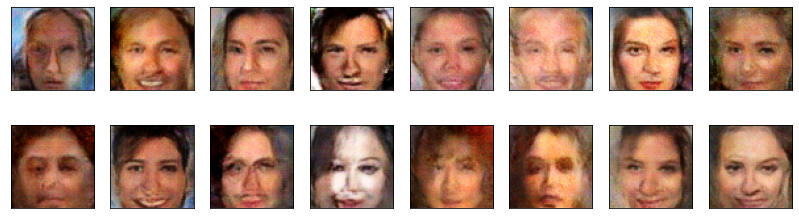

In [23]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        # Update Discriminator multiple times
        for _ in range(5):
            d_loss = discriminator_step(batch_size, latent_dim, real_images)

        # update generator
        g_loss = generator_step(batch_size, latent_dim)
        
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

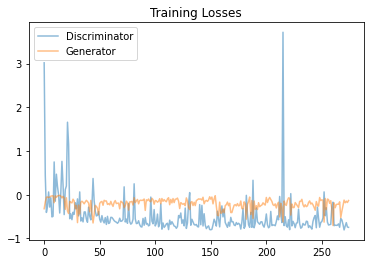

In [24]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** 
- The images generated over the 25 epochs have slowly improved. Thus the following steps can be implemented to improve the model:

1. Increase the number of epochs
2. Fientune the hyperparameters for the optimizer, the gradient penalty
3. The DCGAN model can be improved by using Progressive GAN
4. This model used the Wasserstein Loss with gradient penalty as the BCE loss lead to vanishing gradients. 
5. The diversity in the images may also contribute to improved model. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.